In [1]:
import numpy as np
import cupy as cp

import poppy
from poppy.poppy_core import PlaneType

import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import astropy.units as u
from astropy.io import fits
from pathlib import Path
from IPython.display import clear_output, display

from importlib import reload

import logging, sys
poppy_log = logging.getLogger('poppy')
poppy_log.setLevel('DEBUG')
logging.basicConfig(stream=sys.stdout, level=logging.INFO)

from scoobpsf import scoobm, agpm
reload(scoobm)

import lina
xp = lina.math_module.xp
from lina.imshows import imshow1, imshow2, imshow3

# import misc_funs as misc

poppy_log.disabled = True

pupil_diam = 6.75*u.mm
wavelength_c = 632.8e-9*u.m

dm_flat = fits.getdata(scoobm.module_path/'scoob_dm_flat.fits')

vortex = agpm.IdealAGPM(name='VVC', wavelength=wavelength_c, charge=6, rotation=20)
lyot_stop = poppy.CircularAperture(name='Lyot Stop', radius=3.6*u.mm/2, gray_pixel=False)




Could not import scoobpy. Testbed interface unavailable.


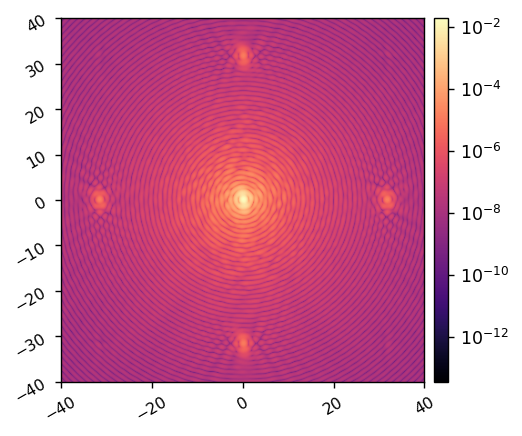

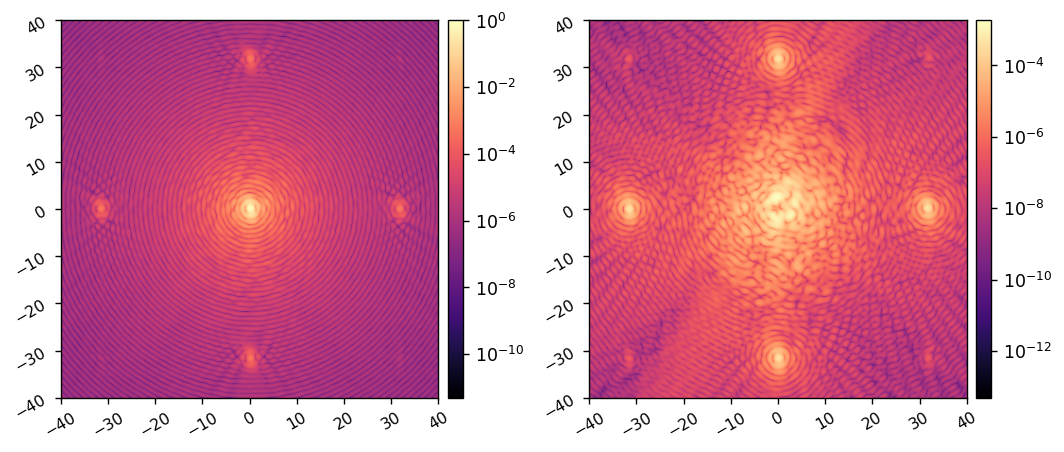

In [35]:
reload(scoobm)
model = scoobm.SCOOBM()
model.npix = 512
model.oversample = 4
model.det_rotation = 0
model.set_dm(dm_flat)

ref_im = model.snap(True)

model.imnorm = ref_im.max()
normalized_im = model.snap()

model.FPM = vortex
model.LYOT = lyot_stop

occ_im = model.snap()
imshow2(normalized_im, occ_im, lognorm1=True, lognorm2=True, pxscl=model.psf_pixelscale_lamD)

Nact = model.Nact
npsf = model.npsf
psf_pixelscale_lamD = model.psf_pixelscale_lamD

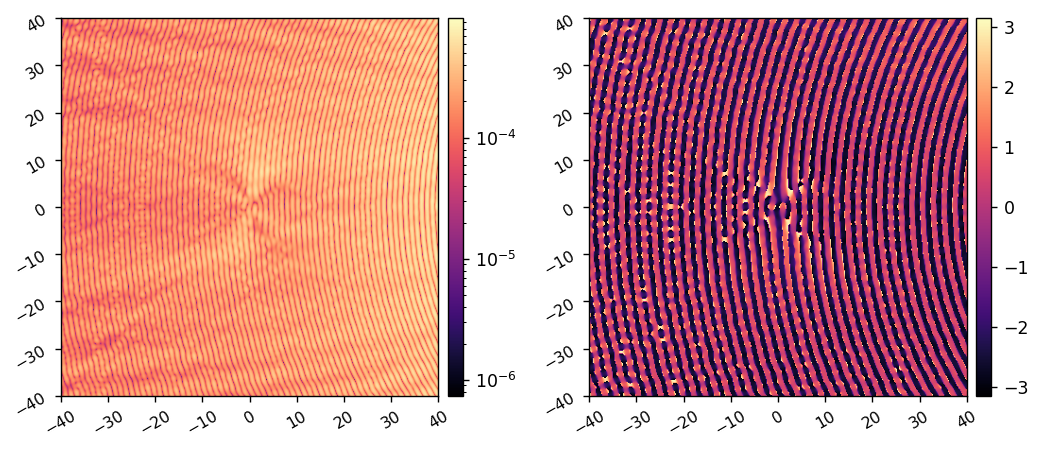

In [36]:
model.source_offset = (100,0)
im = model.calc_psf(True)

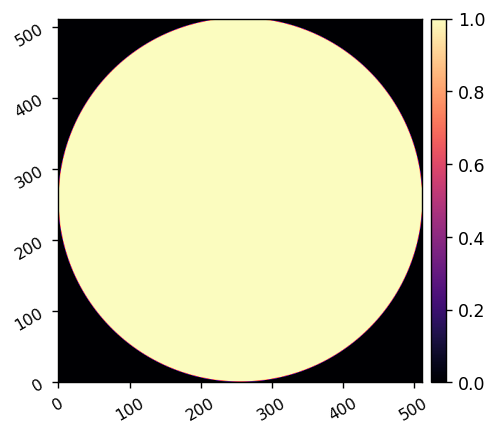

16


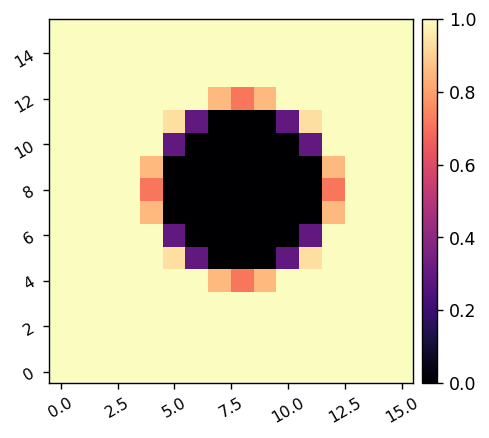

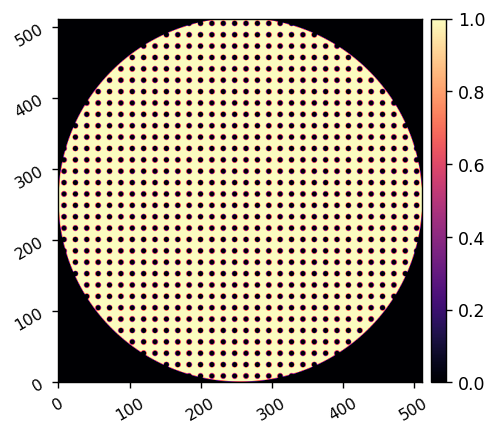

In [50]:
reload(lina.utils)
wf = poppy.FresnelWavefront(beam_radius=pupil_diam/2, npix=model.npix, oversample=1)
ap = poppy.CircularAperture(radius=pupil_diam/2).get_transmission(wf)
imshow1(ap)

grating_period = pupil_diam.to_value(u.m)/34
grating_period_pix = grating_period/wf.pixelscale.to_value(u.m/u.pix)
grating_period_pix = round(grating_period_pix/2)*2
print(grating_period_pix)
# grating_period = 20 # in pixels
grating_obs = lina.utils.pad_or_crop(poppy.InverseTransmission(poppy.CircularAperture(radius=50*u.um)).get_transmission(wf), grating_period_pix)
imshow1(grating_obs)

nobs = model.npix//grating_period_pix

grating = lina.utils.pad_or_crop(xp.tile(grating_obs, (nobs,nobs)), model.npix)*ap
imshow1(grating)

G = poppy.ArrayOpticalElement(transmission=grating, pixelscale=wf.pixelscale)

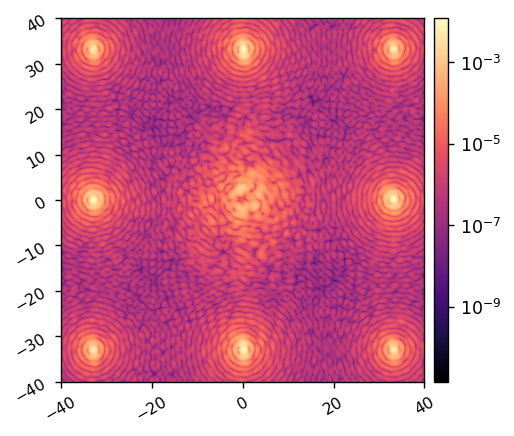

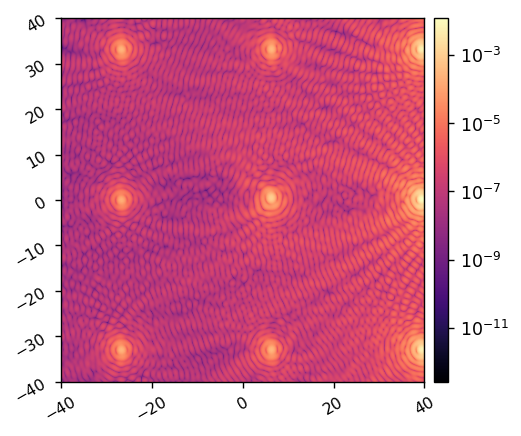

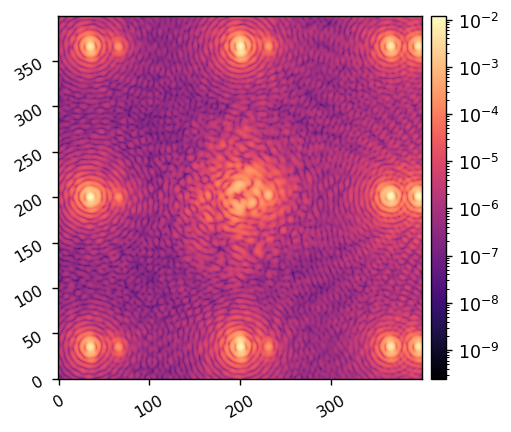

In [51]:
model.OPD = G

model.source_offset = (0,0)
im_on = model.snap(True)

model.source_offset = (70,0)
im_off = model.snap(True)

im = im_on + im_off
imshow1(im, lognorm=True)